# Cascade Classifier for good/bad quality picture

## Imports, Utility Functions

Load dependancy modules

In [2]:
from pandas import DataFrame
from polars import from_pandas
from cv2 import imread, imshow, waitKey, destroyAllWindows
from cv2 import cvtColor, COLOR_BGR2RGB
from glob import glob
from os import walk
from pathlib import Path
from re import match
from time import perf_counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
tqdm.pandas()

Standardize file naming to english to ensure the opencv workflow

In [3]:
def transliterate(dir_path):
    i = 0
    for root,dirs,files in walk(dir_path):
        print(root)
        for file in files:
            path = Path(f'{root}/{file}')
            if (not match(r'[a-zA-Z0-9_\. -]+', file)) & (match(r'.+\.(jpg|JPG|jpeg)', file) is not None):
                i+=1
                path.rename(f"{root}/IMG_{round(perf_counter())}_{i}.jpg") # arbitrary name: the key is guarnteed to be unique
transliterate("cats+dogs")

cats+dogs
cats+dogs/bad_captures
cats+dogs/good_captures


### Load images from a directory utility function

In [19]:
def fetch_images(dir_path, ext='jpg'):
    images = []
    for root, dirs, files in walk(dir_path):
        for dir in dirs:
            images += glob(f'{dir_path}/{dir}/*.{ext}')
        images += glob(f'{dir_path}/*.{ext}')
        images = list(set(images))
    # print(images)
    return images
    # return glob(f'{dir_path}/*.{ext}')

## The workflow

We will split the algorithms into (2-3) different stages:
1. detect + crop the eye in the picture
2. detect sclera, iris and pupil in the frame
3. (if the vets need aditional landmarks) if necessary

In [17]:
def get_boundbox(point1: tuple[float, float], point2: tuple[float, float], scale_factor: float=1.1, ratio: float = 4) -> tuple[float, float, float, float]:
    
    s = scale_factor
    
    # get the centroid and the dx, dy of the points
    x1, y1 = point1
    x2, y2 = point2
    xm, ym = (x1 + x2) / 2, (y2 + y1) / 2
    dx, dy = abs(x1 - x2), abs(y1 - y2)
    
    half_width = dx / 2
    half_height = (dy + dx / ratio) / 2
    box_bounds = (xm -half_width*s,ym -half_height*s,xm +half_width*s,ym +half_height*s)
    
    return box_bounds

In [18]:
get_boundbox((5, 5), (10, 5))

(4.75, 4.3125, 10.25, 5.6875)

### Load the images - look at the shape statistics, see the memory usage

#### Look at the raw data

In [20]:
filenames = fetch_images("cats+dogs")
len(filenames)

146

In [21]:
df = DataFrame({"img": filenames}).astype({'img': 'string'})
df['width'] = df.img.progress_apply(lambda x: imread(x).shape[1]).astype('int32')
df['height'] = df.img.progress_apply(lambda x: imread(x).shape[0]).astype('int32')

  0%|          | 0/146 [00:00<?, ?it/s]

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  0%|          | 0/146 [00:00<?, ?it/s]

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


In [22]:
df

,img,width,height
0,cats+dogs/good_captures/IMG_4563_44.jpg,1658,1583
1,cats+dogs/IMG_4563_16.jpg,1418,1226
2,cats+dogs/IMG_4563_90.jpg,1137,1096
3,cats+dogs/IMG_4563_108.jpg,1303,973
4,cats+dogs/bad_captures/IMG_4563_56.jpg,4248,5664
...,...,...,...
141,cats+dogs/IMG_4563_73.jpg,1105,1043
142,cats+dogs/IMG_4563_76.jpg,674,392
143,cats+dogs/IMG_4563_109.jpg,1739,1303
144,cats+dogs/IMG_4563_25.jpg,1508,1631


We can see that the data that was provided / extracted immidiatly is not labeled - so we need to make clustering manually or by some neat ML algorithm, and check the correctness

#### Now let's look at some statistics about these pictures:

,width,height
min,304,285
25%,1164,929
50%,1413,1173
75%,2133,2055
max,4248,5664


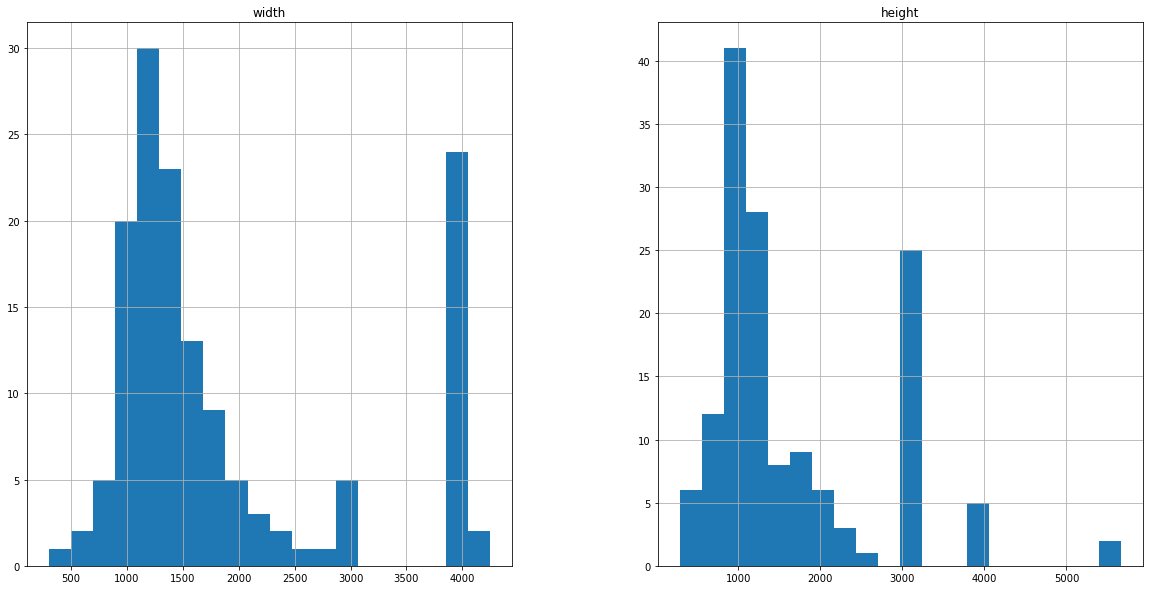

In [23]:
statistics = df[['width','height']].describe()
statistics = statistics[~statistics.index.isin(['count','mean','std'])].astype('int32')
df[['width','height']].hist(bins=20, figsize=(20,10))
display(statistics)

In [8]:
df['img'].info() # 123 pictures, median size 1315x1094 px
print()
df[['width', 'height']].info()

<class 'pandas.core.series.Series'>
RangeIndex: 146 entries, 0 to 145
Series name: img
Non-Null Count  Dtype 
--------------  ----- 
146 non-null    string
dtypes: string(1)
memory usage: 1.3 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   width   146 non-null    int32
 1   height  146 non-null    int32
dtypes: int32(2)
memory usage: 1.3 KB


### Now, Let's take a general look at the images in a dataset, and a look at the statistics benchmark images

In [9]:
def sample_n_images(df, n=10):
    from numpy.random import choice, seed as np_seed
    np_seed(0)
    plt.close()
    for i in list(choice(df.index, n, replace=False)):
        plt.figure(i)
        plt.imshow(cvtColor(imread(df.img[i]), COLOR_BGR2RGB))
    plt.show()

In [10]:
def statistics_benchmark_images(df, statistics):
    for _, (w,h) in enumerate(zip(statistics.width, statistics.height)):
        i = df[(df.width==w) | (df.height==h)].index
        plt.close()
        if len(i) >= 1:
            for j in range(len(i)):
                plt.figure(_+j)
                plt.imshow(cvtColor(imread(df.img[i[j]]), COLOR_BGR2RGB))
        plt.show()

In [11]:
# sample_n_images(df, 10)

In [12]:
# statistics_benchmark_images(df, statistics)

Let's explore the nature of each photo, and determine which ones are good, and which don't

<!-- In the manual for choosing a good picture it's stated that the eyeball should occupy at LEAST 30% of the picture.
- Some thoughts on seperating good pictures from bad: (Tiers of Cascading Classifier)
    - (Tier 1) We can use object detection of the eyeball only to classify the pictures, by the size of the surrounding rectangle.  
      I assume it will be a bit easier to implement / find ( George and Shai to the rescue 😜 )
    - (Tier 1.5) We can use classification model to try seperate between cats and dogs (cats will be supported later in the development).  
      Can be quite challenging since the eyeball occupies most of the picture area (see one tier above)
    - (Tier 2) We can use the specified landmarks that Victor described (EG Iris, Pupil, Sclera, ... ) to filter the images that do not fit (if they were not found) -->


These articles have been published on related topics:
- [Real Time Eye Detector with Cascaded Convolutional Neural Network](https://www.hindawi.com/journals/acisc/2018/1439312/)
- [Developing a diagnosis model for dry eye disease in dogs using object detection](https://www.nature.com/articles/s41598-022-25867-y)
- [CNN-based diagnosis models for canine ulcerative keratitis](https://www.nature.com/articles/s41598-019-50437-0)
- [Deep learning for identifying corneal diseases from ocular surface slit-lamp photographs](https://www.nature.com/articles/s41598-020-75027-3)

In [25]:
def show_pictures_in_grid(df, start, end, grid_size: tuple[int, int] = (3, 4), fig_size:tuple[int,int] = (10, 10)):
    fig = plt.figure(figsize=fig_size)
    
    # setting values to rows and column variables
    rows, columns = grid_size
    size = rows * columns
    # reading images
    images = df.iloc[start:end, df.columns == 'img']
    slice = list(range(start, end))
    # Adds a subplot at the 1st position
    
    for i in trange(size):
        fig.add_subplot(rows, columns, i+1)

        # showing image
        plt.imshow(imread(images.iloc[i,0]))
        plt.axis('off')
        plt.title(f"image {slice[i]+1}")

In [28]:
len(df[df.img.str.contains('good')])

37

  0%|          | 0/12 [00:00<?, ?it/s]

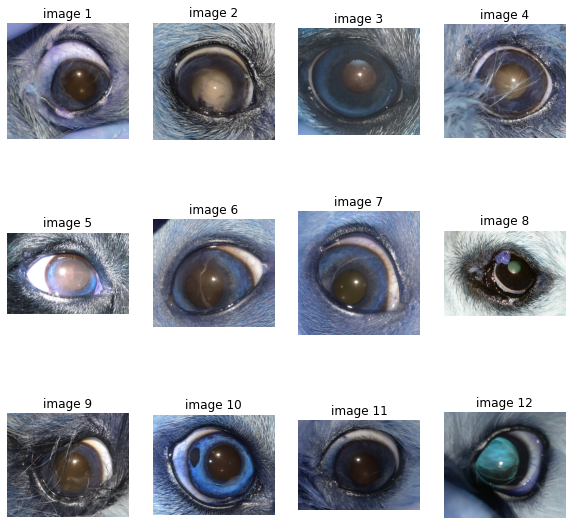

In [26]:
show_pictures_in_grid(df[df.img.str.contains('good')], 0, 12)

## K level detail

In [15]:
# def quantize_img(img, levels):
#     from numpy import float32, uint8
#     from cv2 import kmeans, TERM_CRITERIA_EPS ,TERM_CRITERIA_MAX_ITER, KMEANS_RANDOM_CENTERS, cvtColor, COLOR_BGR2RGB
#     img_rgb = cvtColor(img, COLOR_BGR2RGB)
#     Z = img_rgb.reshape((-1,3))
#     # convert to np.float32
#     Z = float32(Z)
#     # define criteria, number of clusters(K) and apply kmeans()
#     criteria = (TERM_CRITERIA_EPS + TERM_CRITERIA_MAX_ITER, 10, 1.0)
#     K = 2
#     ret,label,center=kmeans(Z, levels,None,criteria,10,KMEANS_RANDOM_CENTERS)
#     # Now convert back into uint8, and make original image
#     center = uint8(center)
#     res = center[label.flatten()]
#     res2 = res.reshape((img.shape))
#     plt.imshow(res2)
#     plt.show()
#     plt.close()

In [16]:
# from numpy.random import seed as np_seed, choice
# from tqdm import tqdm, trange
# np_seed(0)
# img = choice(df.index, 1)[0]
# print(img)
# img = df.img[img]
# # for i in trange(0, 5):
# #     quantize_img(img, 2**(i+1))
# plt.imshow(cvtColor(img, COLOR_BGR2RGB))
# plt.show()
# plt.close()